In [2]:
#import stuff, and set seaborn up
from scipy.stats import norm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import pandas as pd
import time
from scipy.optimize import minimize
from scipy.stats import linregress
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# All the functions

In [2]:
#define functions

#create function that finds mena
def mean_pop(a):
    mean = 0
    for i in range(len(a)):
        mean += a[i]*i

    mean = int(mean/sum(a))

    return mean

#creates random distributions
def brownian_population(delta=2, dt=1, n=100, x=0):

    history=np.zeros(n)
    
    # Iterate to compute the steps of the Brownian motion.
    for i in range(n):
        x = x + norm.rvs(scale=delta**2*dt)
        history[i] = x
    
    history = history+np.abs(np.min(history))
    
    original_hist = np.copy(history)
    old_mean = mean_pop(original_hist)
    
    history = np.round(999*history/sum(history))
    
    mean = np.round(np.average(history))
    
    if sum(history) < 999:
        history[0] += 999-sum(history)
        
    elif sum(history) > 999:  
        history[np.argmax(history)] -= -999+sum(history)        
    

    return history, old_mean, original_hist

#create function that finds true positive rates as a function of the cutoff
def true_positive_rate(population, population_that_defaulted, cutoff):
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    number_true_positives = sum(true_positives)
    
    false_negatives = np.logical_and(np.logical_not(population_that_defaulted), 
                                     population_bank_thinks_defaulted)
    
    number_false_negatives = sum(false_negatives) 
    
    true_positive_rate = number_true_positives/(number_true_positives+number_false_negatives)
    
    return true_positive_rate

def difference_bw_positive_rates(pop1, pop2, pop1_that_defaulted, 
                                 pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    true_positive_rate_group1 = true_positive_rate(pop1, pop1_that_defaulted, cutoff1)
    true_positive_rate_group2 = true_positive_rate(pop2, pop2_that_defaulted, cutoff2)
    # for the optimiser's constraints
    return strictness - np.abs(true_positive_rate_group1-true_positive_rate_group2)

def difference_bw_selection_rates(pop1, pop2, pop1_that_defaulted, 
                                  pop2_that_defaulted, cutoff1, cutoff2, strictness=0.01):
    
    _, selection_rate_group1, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    _, selection_rate_group2, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return strictness - np.abs(selection_rate_group1-selection_rate_group2)

#create function that finds bank profit as a function of the cutoff
def bank_profit(population, population_that_defaulted, cutoff, 
                revenue_factor=1, cost_factor=3, credit_upside=1, credit_downside=2):
    
    population_bank_thinks_defaulted = population < cutoff
    
    true_positives = np.logical_and(np.logical_not(population_that_defaulted), 
                                    np.logical_not(population_bank_thinks_defaulted))
    
    paid_back = sum(true_positives)
    false_positives = np.logical_and(population_that_defaulted, 
                                     np.logical_not(population_bank_thinks_defaulted))
    defaulted = sum(false_positives)
    
    profit = paid_back*revenue_factor - defaulted*cost_factor
    selection_rate = sum(np.logical_not(population_bank_thinks_defaulted))/len(population)
    
    credit_change = (paid_back*credit_upside - defaulted*credit_downside)

    
    return profit, selection_rate, credit_change

def total_bank_profit(pop1, pop2, pop1_that_defaulted, pop2_that_defaulted, cutoff1, cutoff2, 
                      revenue_factor=1, cost_factor=2, credit_upside=1, credit_downside=2):
    
    profit_group1, _, _ = bank_profit(pop1, pop1_that_defaulted, cutoff1)
    profit_group2, _, _ = bank_profit(pop2, pop2_that_defaulted, cutoff2)
    
    return -(profit_group1 + profit_group2)

def create_blues_and_oranges():
    a, mean_a, _ = brownian_population()
    b, mean_b, _ = brownian_population()

    if mean_a >= mean_b:
        blues = np.copy(b)
        oranges = np.copy(a)
    elif mean_a < mean_b:
        blues = np.copy(a)
        oranges = np.copy(b)
    else:
        print("um")

    true_blues = np.zeros(1)
    true_oranges = np.zeros(1)
    
    for i in range(100):
        num_blues = int(blues[i])
        num_oranges = int(oranges[i])
        
        if num_blues >= 0 and num_oranges >= 0:

            elements_blues = np.multiply(np.ones(num_blues),i)
            elements_oranges = np.multiply(np.ones(num_oranges), i)

            true_blues = np.concatenate((true_blues, elements_blues), axis=0)
            true_oranges = np.concatenate((true_oranges, elements_oranges), axis=0)

    #determine who defaulted
    blues_who_defaulted = true_blues < np.random.randint(100, size=(1000,))
    oranges_who_defaulted = true_oranges < np.random.randint(100, size=(1000,))

    blues = true_blues
    oranges = true_oranges
    
    return blues, oranges, blues_who_defaulted, oranges_who_defaulted, mean_a, mean_b
    

## Find a way to create populations

In [3]:
a, mean_a, _ = brownian_population()
b, mean_b, _ = brownian_population()

if mean_a > mean_b:
    blues = np.copy(b)
    oranges = np.copy(a)
else:
    blues = np.copy(a)
    oranges = np.copy(b)
    
true_blues = np.zeros(1)
true_oranges = np.zeros(1)

for i in range(100):
    num_blues = int(blues[i])
    num_oranges = int(oranges[i])
    elements_blues = np.multiply(np.ones(num_blues),i)
    elements_oranges = np.multiply(np.ones(num_oranges), i)
    
    true_blues = np.concatenate((true_blues, elements_blues), axis=0)
    true_oranges = np.concatenate((true_oranges, elements_oranges), axis=0)
    
#determine who defaulted
blues_who_defaulted = true_blues.T < np.random.randint(100, size=(1000,))
oranges_who_defaulted = true_oranges.T < np.random.randint(100, size=(1000,))

blues = true_blues.T
oranges = true_oranges.T

## Plot populations

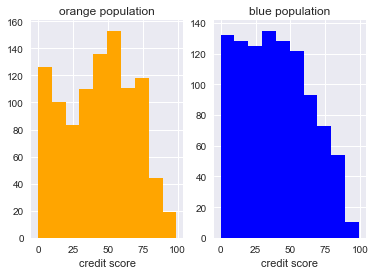

In [4]:
plt.subplot(121)
plt.hist(oranges, bins=10, color="orange")
plt.xlabel("credit score")
plt.title("orange population")
plt.subplot(122)
plt.hist(blues, bins=10, color="b")
plt.xlabel("credit score")
plt.title("blue population")
plt.show()


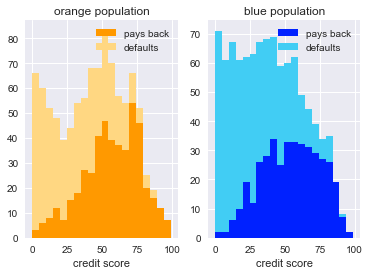

In [5]:
plt.subplot(121)
plt.hist([true_oranges[np.logical_not(oranges_who_defaulted)],true_oranges[oranges_who_defaulted]], 
         stacked=True, bins=20, color=("#ff9900", "#ffd782"))
plt.legend(("pays back", "defaults"))
plt.title("orange population")
plt.xlabel("credit score")
plt.subplot(122)
plt.hist([true_blues[np.logical_not(blues_who_defaulted)],true_blues[blues_who_defaulted]], 
         stacked=True, bins=20, color=("#0021ff", "#41cdf4"))
plt.legend(("pays back", "defaults"))
plt.title("blue population")
plt.xlabel("credit score")
plt.show()

## Optimise for the first time

In [6]:
#what to optimise
to_optimise = lambda x: total_bank_profit(blues, oranges, blues_who_defaulted, 
                                          oranges_who_defaulted, x[0], x[1])

to_constrain = lambda x: difference_bw_positive_rates(blues, oranges, blues_who_defaulted, 
                                                      oranges_who_defaulted, x[0], x[1])

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50
#show initial objective
print("initial guess of", cutoffs, "got us a profit of ", -to_optimise(cutoffs), "$")

initial guess of [50. 50.] got us a profit of  -183 $


### With fairness

In [7]:
#optimise with fairness
a = (0, 100)
bounds = (a, a)
equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
cons = ([equal_true_positives])

solution = minimize(to_optimise, cutoffs, 
#                     method='SLSQP', 
                    constraints = cons,
                    bounds=bounds, 
                    options = {'eps': 3})


x_fair = solution.x

In [8]:
print(x_fair)

#final solution got us a profit of:
print("final guess of", x_fair, "got us a profit of ", -to_optimise(x_fair), "$")

_, _, blues_credit_change = bank_profit(blues, blues_who_defaulted, x_fair[0])
_, _, oranges_credit_change = bank_profit(oranges, oranges_who_defaulted, x_fair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change, 
      "|| total credit score change for oranges:", oranges_credit_change)

[66.05336952 69.46289998]
final guess of [66.05336952 69.46289998] got us a profit of  104 $
total credit score change for blues: 61 || total credit score change for oranges: 103


### Without fairness

In [9]:
#optimise without fairness
a = (0, 100)
bounds = (a, a)

solution_unfair = minimize(to_optimise, cutoffs, method='SLSQP',
                    bounds=bounds, options = {'eps': 3})

x_unfair = solution_unfair.x

In [10]:
#final solution got us a profit of:
print("final guess of", x_unfair, "got us a profit of ", -to_optimise(x_unfair), "$")

_, _, blues_credit_change = bank_profit(blues, blues_who_defaulted, x_unfair[0])
_, _, oranges_credit_change = bank_profit(oranges, oranges_who_defaulted, x_unfair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change, 
      "|| total credit score change for oranges:", oranges_credit_change)

final guess of [66.62029261 70.0097284 ] got us a profit of  107 $
total credit score change for blues: 61 || total credit score change for oranges: 102


# Do this all systematically

## 1. With BOTH!

In [11]:

num_its = 200

profit_eq_opt = np.zeros(num_its)
credit_change_blues_eq_opt = np.zeros(num_its)
credit_change_oranges_eq_opt = np.zeros(num_its)
cutoffs_eq_opt = np.zeros((num_its, 2))

population_log_blues = np.zeros((num_its, 1000))
population_log_oranges = np.zeros((num_its, 1000))

profit_no_fairness = np.zeros(num_its)
credit_change_blues_no_fairness = np.zeros(num_its)
credit_change_oranges_no_fairness = np.zeros(num_its)
cutoffs_no_fairness = np.zeros((num_its, 2))

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50



#impose bounds
a = (0, 100)
bounds = (a, a)

how_long_did_it_take = time.time()

for i in range(num_its):
    t = time.time()
    

    
    blues, oranges, blues_who_defaulted, oranges_who_defaulted, _, _ = create_blues_and_oranges()
    
    
    
    population_log_blues[i] = blues
    population_log_oranges[i] = oranges
    
    to_constrain = lambda x: difference_bw_positive_rates(blues, oranges, blues_who_defaulted, 
                                                          oranges_who_defaulted, x[0], x[1])
    
    
    
    #optimise bank profit
    to_optimise = lambda x: total_bank_profit(blues, oranges, blues_who_defaulted, 
                                      oranges_who_defaulted, x[0], x[1])
    
    
    equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
    cons = ([equal_true_positives])
    
    solution_fair = minimize(to_optimise, cutoffs, method='SLSQP', 
                        constraints = cons, bounds=bounds, options = {'eps': 3, 'maxiter': 10})

    x_fair = solution_fair.x
    
    cutoffs_eq_opt[i] = x_fair

    profit_eq_opt[i] = -to_optimise(x_fair)
    _, _, credit_change_blues_eq_opt[i] = bank_profit(blues, blues_who_defaulted, x_fair[0])
    _, _, credit_change_oranges_eq_opt[i] = bank_profit(oranges, oranges_who_defaulted, x_fair[1])
    
    solution_unfair = minimize(to_optimise, cutoffs, method='SLSQP', 
                        bounds=bounds, options = {'eps': 3})

    x_unfair = solution_unfair.x
    
    profit_no_fairness[i] = -to_optimise(x_unfair)
    _, _, credit_change_blues_no_fairness[i] = bank_profit(blues, blues_who_defaulted, x_unfair[0])
    _, _, credit_change_oranges_no_fairness[i] = bank_profit(oranges, oranges_who_defaulted, x_unfair[1])
    
    cutoffs_no_fairness[i] = x_unfair
    
    if (i % 50 == 0):
        print("iteration", i, "(which took", time.time() - t, "seconds).")
    
    print(i)

print("This took long to run,", (time.time() - how_long_did_it_take)/60, "minutes to be exact.")

iteration 0 (which took 4.748297929763794 seconds).
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
iteration 50 (which took 3.3017730712890625 seconds).
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
iteration 100 (which took 1.2629997730255127 seconds).
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
iteration 150 (which took 1.5006310939788818 seconds).
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
This took long to run, 8.304583684603374 minutes to be exact.


## Plot distributions of populations under fairness and no fairness constraints

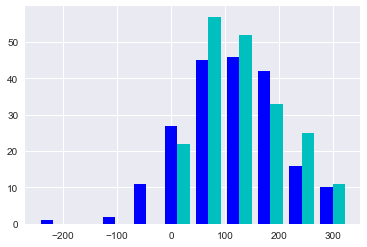

In [12]:
plt.hist((credit_change_blues_eq_opt, credit_change_blues_no_fairness), color=("b", "c"))
plt.show()

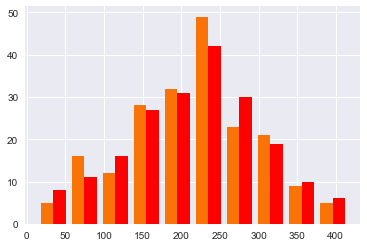

In [13]:
plt.hist((credit_change_oranges_eq_opt, credit_change_oranges_no_fairness), color=("xkcd:orange", "r"))
plt.show()

In [14]:
print("Fairness blues got", sum(credit_change_blues_eq_opt), 
      "whereas unfair blues got", sum(credit_change_blues_no_fairness))

print("Fairness oranges got", sum(credit_change_oranges_eq_opt), 
      "whereas unfair oranges got", sum(credit_change_oranges_no_fairness))

Fairness blues got 23053.0 whereas unfair blues got 26546.0
Fairness oranges got 42825.0 whereas unfair oranges got 43360.0


In [15]:
comparisons_smaller = credit_change_blues_eq_opt < credit_change_blues_no_fairness
comparisons_bigger = credit_change_blues_eq_opt > credit_change_blues_no_fairness
comparisons_equal = np.abs(credit_change_blues_eq_opt - credit_change_blues_no_fairness) < 3

# Generate pretty plots

1. What's the gap between unfair and fair classification
2. What do the distributions look like?
3. How many people default?


### 1. What's the gap between unfair and fair classification

In [16]:
average_blue = np.average(population_log_blues, axis=0)
average_orange = np.average(population_log_oranges, axis=0)
average_distance = average_orange[:200]-average_blue[:200]
average_distance.shape

(200,)

In [17]:
average_blue[200]

17.595

In [18]:
print(average_distance)

[ 0.     0.09   0.175  0.275  0.415  0.515  0.58   0.705  0.9    1.02
  1.19   1.34   1.39   1.47   1.505  1.645  1.73   1.78   1.825  1.875
  1.965  2.05   2.08   2.16   2.255  2.315  2.375  2.445  2.52   2.61
  2.76   2.805  2.86   2.93   3.02   3.105  3.18   3.245  3.27   3.37
  3.405  3.505  3.535  3.655  3.66   3.7    3.795  3.865  3.9    4.015
  4.1    4.155  4.225  4.27   4.385  4.4    4.51   4.555  4.6    4.715
  4.82   4.865  4.91   4.965  5.015  5.095  5.155  5.205  5.25   5.29
  5.335  5.43   5.41   5.455  5.47   5.56   5.595  5.685  5.73   5.82
  5.825  5.85   5.92   5.915  5.97   6.05   6.085  6.135  6.165  6.185
  6.21   6.29   6.395  6.43   6.48   6.555  6.58   6.66   6.695  6.775
  6.835  6.915  6.935  6.925  6.995  7.025  7.02   7.07   7.135  7.205
  7.26   7.295  7.32   7.355  7.37   7.42   7.48   7.54   7.59   7.58
  7.625  7.67   7.695  7.77   7.795  7.825  7.835  7.895  7.91   7.96
  7.985  8.03   8.045  8.085  8.135  8.185  8.21   8.29   8.335  8.365
  8.385  8.38

In [19]:
frame = np.concatenate((credit_change_blues_eq_opt.reshape(200,1), 
                        credit_change_oranges_eq_opt.reshape(200,1), 
                        credit_change_blues_no_fairness.reshape(200,1), 
                        credit_change_oranges_no_fairness.reshape(200,1)), axis=1)

change_for_blues = np.concatenate((credit_change_blues_eq_opt.reshape(200,1), 
                                   credit_change_blues_no_fairness.reshape(200,1),
                                   average_distance.reshape(200,1)), 
                                  axis=1)

credit_changes_blue = pd.DataFrame(change_for_blues)
credit_changes_blue.columns = ["blue with equal opportunity",
                               "blue with no constraints",
                               "average distance"]


credit_changes = pd.DataFrame(frame)
credit_changes.columns = ["blue with equal opportunity", 
                          "orange with equal opportunity", 
                          "blue with no constraint", 
                          "oranges with no constraint"]

In [20]:
credit_changes_blue["distance"] = credit_changes_blue["blue with no constraints"] - credit_changes_blue["blue with equal opportunity"]

credit_changes_blue = credit_changes_blue.sort_values("distance", ascending=False)

credit_changes_blue["sorted index"] = np.arange(200)
credit_changes_blue.head()

,blue with equal opportunity,blue with no constraints,average distance,distance,sorted index
5,-247.0,79.0,0.515,326.0,0
195,-94.0,63.0,10.425,157.0,1
172,-46.0,100.0,9.545,146.0,2
143,-20.0,124.0,8.415,144.0,3
131,-18.0,115.0,8.030,133.0,4


In [1]:
plt.hist(credit_changes_blue['average distance'])
plt.show()

NameError: name 'plt' is not defined

# HERHEHEHREHRHERE

In [21]:
workblue = np.copy(population_log_blues[168])
workorange = np.copy(population_log_oranges[168])
workblue_defaults = workblue < np.random.randint(100, size=(1000,))
workorange_defaults = workorange < np.random.randint(100, size=(1000,))

In [22]:
#what to optimise
to_optimise = lambda x: total_bank_profit(workblue, workorange, workblue_defaults, 
                                          workorange_defaults, x[0], x[1])

to_constrain = lambda x: difference_bw_positive_rates(workblue, workorange, workblue_defaults, 
                                                      workorange_defaults, x[0], x[1])

#initial guess
cutoffs = np.zeros(2)
cutoffs[0] = 50
cutoffs[1] = 50
#show initial objective
print("initial guess of", cutoffs, "got us a profit of ", -to_optimise(cutoffs), "$")

initial guess of [50. 50.] got us a profit of  13 $


### With fairness

In [23]:
#optimise with fairness
a = (0, 100)
bounds = (a, a)
equal_true_positives = {'type': 'ineq', 'fun': to_constrain}
cons = ([equal_true_positives])

solution = minimize(to_optimise, cutoffs, method='SLSQP', constraints = cons,
                    bounds=bounds, options = {'eps': 3, 'maxiter':10})

x_fair = solution.x

print(x_fair)

#final solution got us a profit of:
print("final guess of", x_fair, "got us a profit of ", -to_optimise(x_fair), "$")

_, _, blues_credit_change = bank_profit(workblue, workblue_defaults, x_fair[0])
_, _, oranges_credit_change = bank_profit(workorange, workorange_defaults, x_fair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change, 
      "|| total credit score change for oranges:", oranges_credit_change)

[44.79320773 73.39524552]
final guess of [44.79320773 73.39524552] got us a profit of  104 $
total credit score change for blues: -7 || total credit score change for oranges: 228


In [24]:
print(sum(np.logical_and(workblue > 31.2, np.logical_not(workblue_defaults))), "this is true positive")
print(sum(np.logical_and(workblue > 31.09, workblue_defaults)), "false positive")

print(sum(np.logical_and(workorange > 58.2, np.logical_not(workorange_defaults))), "this is true positive")
print(sum(np.logical_and(workorange > 58.09, workorange_defaults)), "false positive")

199 this is true positive
185 false positive
381 this is true positive
83 false positive


### Without fairness

In [25]:
#optimise without fairness
a = (0, 100)
bounds = (a, a)

solution_unfair = minimize(to_optimise, cutoffs, method='SLSQP',
                    bounds=bounds, options = {'eps': 3})

x_unfair = solution_unfair.x

#final solution got us a profit of:
print("final guess of", x_unfair, "got us a profit of ", -to_optimise(x_unfair), "$")

_, _, blues_credit_change = bank_profit(workblue, workblue_defaults, x_unfair[0])
_, _, oranges_credit_change = bank_profit(workorange, workorange_defaults, x_unfair[1])
#final solution got us a change in credit score of:
print("total credit score change for blues:", blues_credit_change, 
      "|| total credit score change for oranges:", oranges_credit_change)

print(sum(np.logical_and(workblue > x_unfair[0], np.logical_not(workblue_defaults))), "this is true positive")
print(sum(np.logical_and(workblue > x_unfair[0], workblue_defaults)), "false positive")

print(sum(np.logical_and(workorange > x_unfair[1], np.logical_not(workorange_defaults))), "this is true positive")
print(sum(np.logical_and(workorange > x_unfair[1], workorange_defaults)), "false positive")

final guess of [80.34055878 75.02942268] got us a profit of  248 $
total credit score change for blues: 51 || total credit score change for oranges: 228
61 this is true positive
5 false positive
280 this is true positive
26 false positive


In [26]:
loans_b = workblue < x_fair[0]
true_positives_b = np.logical_and(np.logical_not(loans_b), np.logical_not(workblue_defaults))
false_positives_b = np.logical_and(np.logical_not(loans_b), workblue_defaults)


loans_o = workorange < x_fair[1]
true_positives_o = np.logical_and(np.logical_not(loans_o), np.logical_not(workorange_defaults))
false_positives_o = np.logical_and(np.logical_not(loans_o), workorange_defaults)

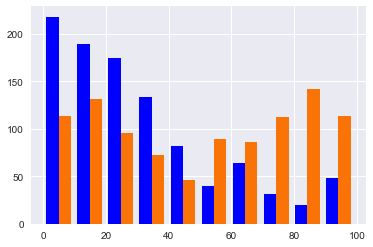

In [27]:
plt.hist([workblue, workorange], color=['b', 'xkcd:orange'])
plt.show()

In [28]:
workblue_fair = np.copy(workblue)
workorange_fair = np.copy(workorange)

workblue_fair[true_positives_b] +=10
workblue_fair[false_positives_b] -=20
workblue_fair[workblue_fair<1] = 1
workblue_fair[workblue_fair>99] = 99

workorange_fair[true_positives_o] +=10
workorange_fair[false_positives_o] -=20
workorange_fair[workorange_fair<1] = 1
workorange_fair[workorange_fair>99] = 99

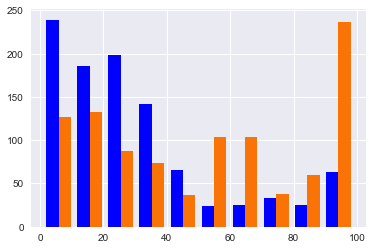

In [29]:
plt.hist([workblue_fair, workorange_fair], color=['b', 'xkcd:orange'])
plt.show()

In [30]:
loans_b = workblue < x_unfair[0]
true_positives_b = np.logical_and(np.logical_not(loans_b), np.logical_not(workblue_defaults))
false_positives_b = np.logical_and(np.logical_not(loans_b), workblue_defaults)


loans_o = workorange < x_unfair[1]
true_positives_o = np.logical_and(np.logical_not(loans_o), np.logical_not(workorange_defaults))
false_positives_o = np.logical_and(np.logical_not(loans_o), workorange_defaults)

In [31]:
workblue_unfair = np.copy(workblue)
workorange_unfair = np.copy(workorange)

workblue_unfair[true_positives_b] +=10
workblue_unfair[false_positives_b] -=20
workblue_unfair[workblue_unfair<1] = 1
workblue_unfair[workblue_unfair>99] = 99

workorange_unfair[true_positives_o] +=10
workorange_unfair[false_positives_o] -=20
workorange_unfair[workorange_unfair<1] = 1
workorange_unfair[workorange_unfair>99] = 99

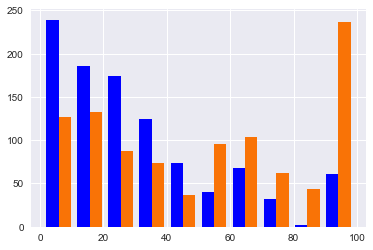

In [32]:
plt.hist([workblue_unfair, workorange_unfair], color=['b', 'xkcd:orange'])
plt.show()

In [33]:
print(sum(workblue_unfair<50), sum(workblue_fair<50))

797 830


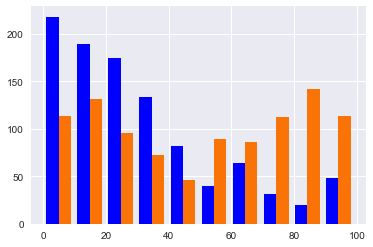

In [34]:
plt.hist([population_log_blues[168], population_log_oranges[168]], color=['b', 'xkcd:orange'])
plt.show()

In [35]:
sum(credit_changes_blue["average distance"] < 0)

0

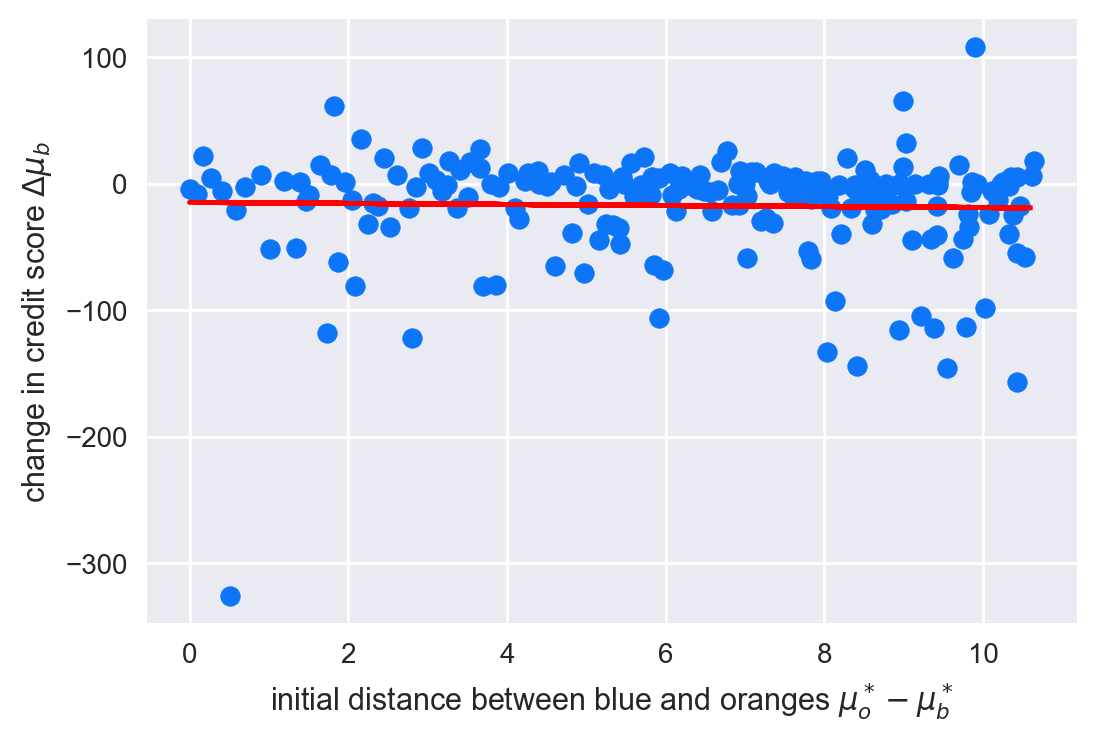

In [36]:
plt.figure(dpi=200)

credit_changes_blue_sub = credit_changes_blue.sample(200)

trendline = np.polyfit(credit_changes_blue_sub["average distance"],- credit_changes_blue_sub["distance"], 1)
p = np.poly1d(trendline)
plt.scatter(credit_changes_blue_sub["average distance"],-credit_changes_blue_sub["distance"], c='xkcd:deep sky blue')
plt.plot(credit_changes_blue["average distance"], p(credit_changes_blue["average distance"]), "r--")
plt.ylabel("change in credit score $\Delta\mu_b$")
plt.xlabel("initial distance between blue and oranges $\mu^*_o - \mu^*_b$")
plt.savefig("plots/big_sim/GOOD_p_rule_worse_doesnt_help.pdf")
plt.show()

In [37]:
print(linregress(credit_changes_blue_sub["average distance"],-credit_changes_blue_sub["distance"]))

LinregressResult(slope=-0.4082559579535897, intercept=-14.895437000640106, rvalue=-0.02733492209755321, pvalue=0.7008132295821226, stderr=1.0610107475537731)


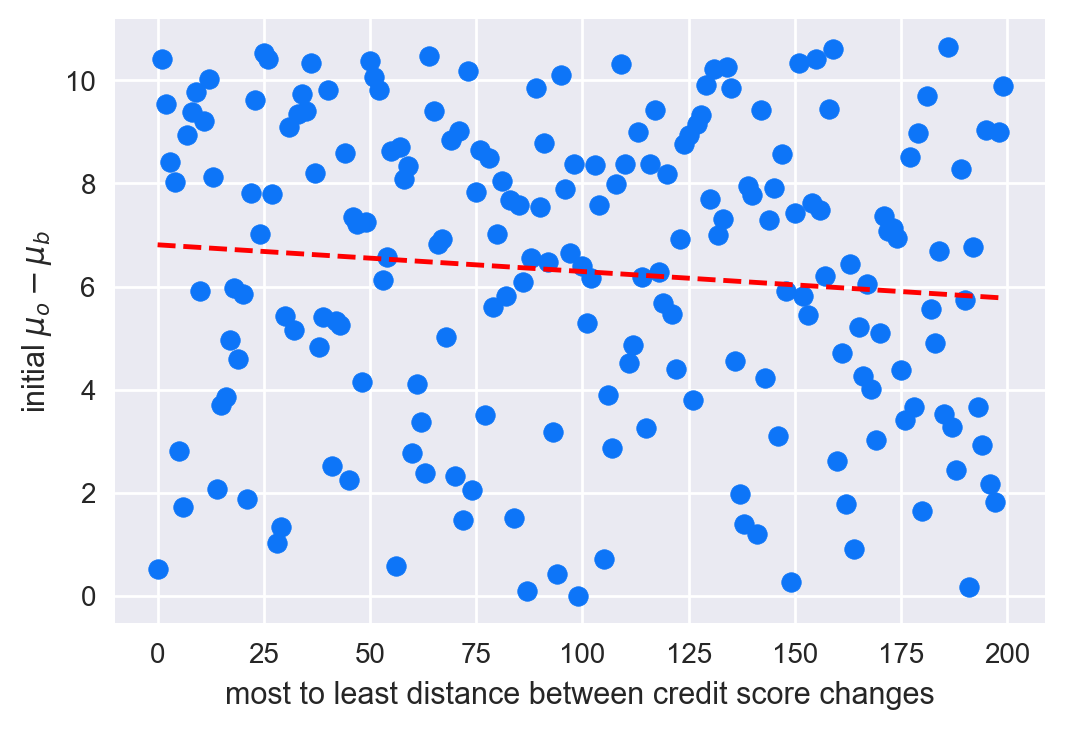

In [38]:
plt.figure(dpi=200)

credit_changes_blue_sub = credit_changes_blue.sample(200)

trendline = np.polyfit(credit_changes_blue_sub["sorted index"], credit_changes_blue_sub["average distance"], 1)
p = np.poly1d(trendline)
plt.scatter(credit_changes_blue_sub["sorted index"],credit_changes_blue_sub["average distance"], c='xkcd:deep sky blue')
plt.plot(credit_changes_blue["sorted index"], p(credit_changes_blue["sorted index"]), "r--")
plt.ylabel("initial $\mu_o - \mu_b$")
plt.xlabel("most to least distance between credit score changes")
plt.savefig("plots/big_sim/p_rule_worse_doesnt_help.pdf")
plt.show()

In [39]:
print(linregress(credit_changes_blue_sub["sorted index"],credit_changes_blue_sub["average distance"]))

LinregressResult(slope=-0.0051867246681167045, intercept=6.8100791044776114, rvalue=-0.10357528085677362, pvalue=0.1444212918759204, stderr=0.0035396667290981476)


In [40]:
credit_changes_blue.tail()

,blue with equal opportunity,blue with no constraints,average distance,distance,sorted index
160,129.0,97.0,9.030,-32.0,195
23,155.0,120.0,2.160,-35.0,196
18,61.0,0.0,1.825,-61.0,197
157,165.0,100.0,8.995,-65.0,198
181,108.0,0.0,9.895,-108.0,199


In [41]:
print(credit_changes_blue.index[-2])
distance_far = 0
distance_close = 0
distance_medium = 0
for i in range(20):
    index = credit_changes_blue.index[i]
    distance_far += np.average(population_log_oranges[index]) - np.average(population_log_blues[index])

for i in range(20):
    index = credit_changes_blue.index[-i]
    distance_close += np.average(population_log_oranges[index]) - np.average(population_log_blues[index])
    
    
for i in range(20):
    index = credit_changes_blue.index[i+100]
    distance_medium +=np.average(population_log_oranges[index]) - np.average(population_log_blues[index])
print("far=",distance_far/20, "|| close=",distance_close/20, "|| medium=", distance_medium/20)

157
far= 15.000099999999998 || close= 9.645800000000001 || medium= 11.907500000000002


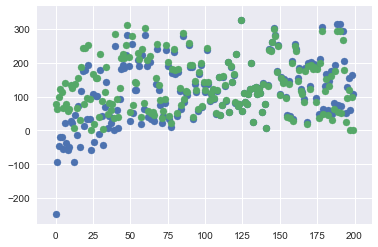

16


In [42]:
plt.scatter(credit_changes_blue["sorted index"], credit_changes_blue["blue with equal opportunity"])
plt.scatter(credit_changes_blue["sorted index"], credit_changes_blue["blue with no constraints"])
plt.show()
print(sum(credit_changes_blue["blue with equal opportunity"] < 0))

In [43]:
print(sum(credit_changes_blue["blue with equal opportunity"] - credit_changes_blue["blue with no constraints"] < 0))

121


In [44]:
stats = credit_changes_blue["blue with equal opportunity"] - credit_changes_blue["blue with no constraints"]

In [45]:
print(sum(stats < -1))
print(sum(stats > 1))
print(len(stats))

114
61
200


In [46]:
print(sum(credit_changes_blue['distance'] < 0))

66


In [47]:
print(sum(credit_changes_blue["distance"] > 1))
print(sum(credit_changes_blue["distance"] < -1))

small = credit_changes_blue["distance"] <= 1
butbig = credit_changes_blue["distance"] >= -1
medium = np.logical_and(small, butbig)
print(sum(medium))

114
61
25


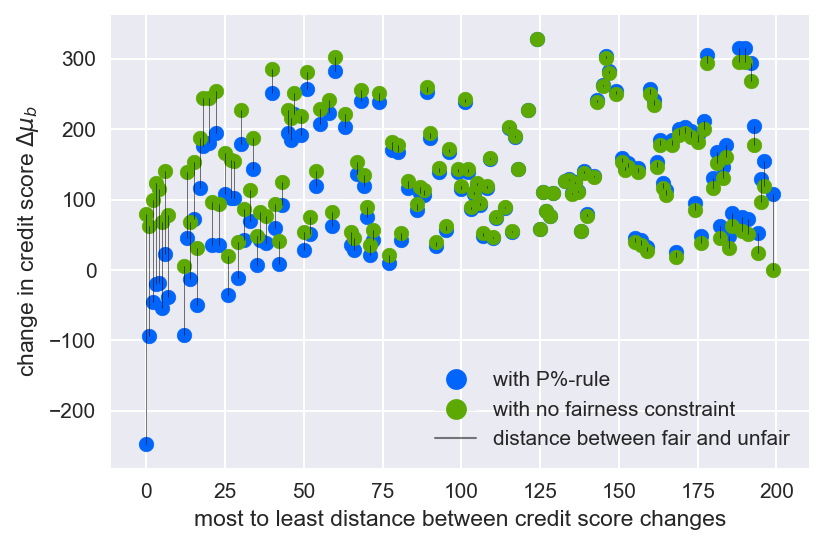

In [48]:
subsampled_credit_changes = credit_changes_blue.sample(150)

average_no_fairness = np.average(subsampled_credit_changes["blue with no constraints"])
average_eq_opt = np.average(subsampled_credit_changes["blue with equal opportunity"])


legend_elements = [Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='with P%-rule',
                          markerfacecolor='xkcd:bright blue', markersize=10),
                   Line2D([0], [0], marker='o', color=(234/255, 234/255, 242/255), label='with no fairness constraint',
                          markerfacecolor='xkcd:leaf green', markersize=10),
                   Line2D([0], [0], label='distance between fair and unfair', 
                          color='black', markersize=3, linewidth=1, alpha=0.5)
                  ]

fig, ax = plt.subplots()

fig.set_dpi(150)

# plt.legend(["with equal opportunity", "with no fairness constraint"])
           
for i in range(len(subsampled_credit_changes.values)):
    ax.plot(subsampled_credit_changes['sorted index'].values[i]*np.ones((2, 1)),
                             [subsampled_credit_changes['blue with equal opportunity'].values[i], 
                              subsampled_credit_changes['blue with no constraints'].values[i]], 
                             c='black', linewidth=0.25)

ax.scatter(subsampled_credit_changes["sorted index"], subsampled_credit_changes["blue with equal opportunity"], 
            c="xkcd:bright blue")
ax.scatter(subsampled_credit_changes["sorted index"], subsampled_credit_changes["blue with no constraints"], 
            c='xkcd:leaf green')


ax.set_ylabel("change in credit score $\Delta\mu_b$")
ax.set_xlabel("most to least distance between credit score changes")
ax.legend(handles = legend_elements, loc='best')
plt.savefig("plots/big_sim/p_rule_distance_between_score_changes.pdf")
plt.show()

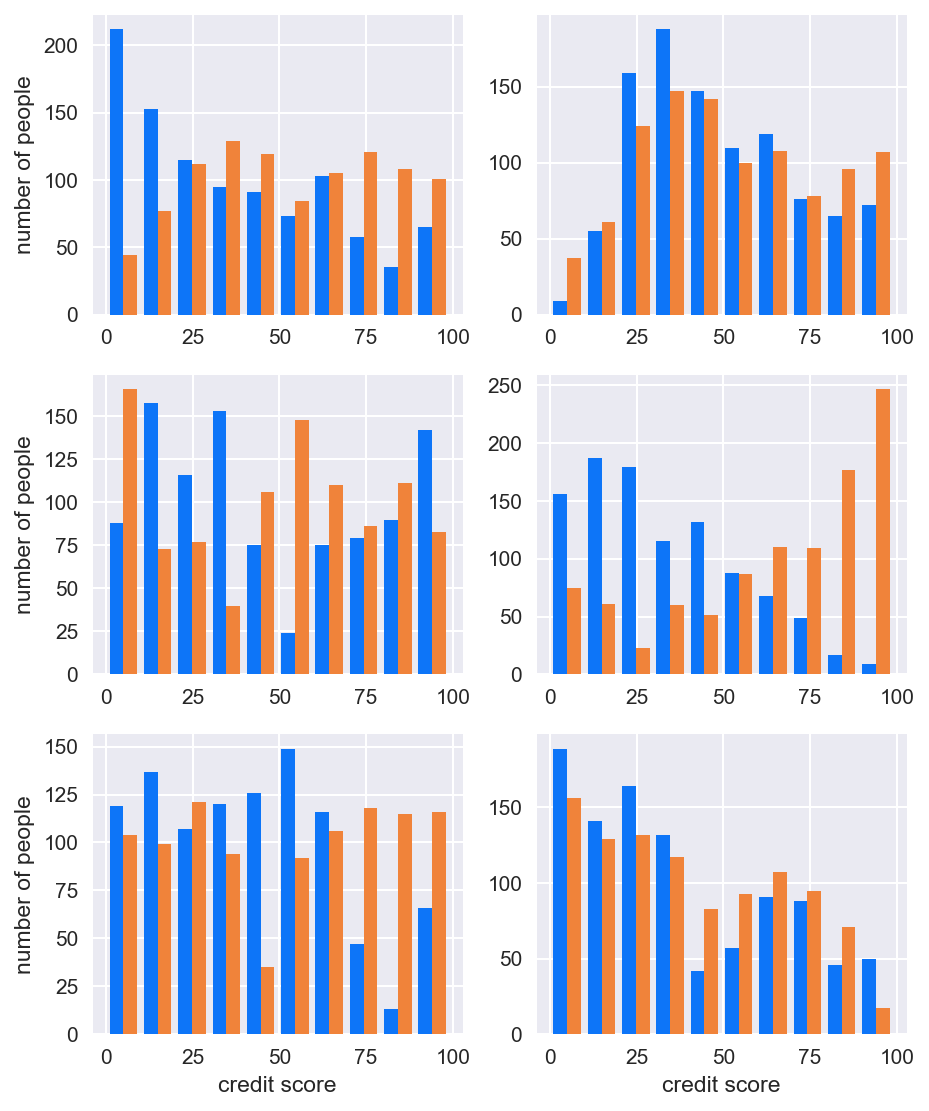

In [49]:
plt.figure(figsize=(7,9), dpi=150)       
sns.set_palette("Paired")


# fig = plt.figure()
# ax = plt.subplot(111)

# for i in xrange(5):
#     ax.plot(x, i * x, label='$y = %ix$' % i)

# ax.legend(bbox_to_anchor=(1.1, 1.05))


for i in range(6):
    a, b, c, d, mean_a, mean_b = create_blues_and_oranges()
    plt.subplot(3, 2, i+1)

    plt.hist([a, b], color=['xkcd:deep sky blue', 'xkcd:dusty orange'])
    
    if(i==0):
        plt.ylabel("number of people")
#         plt.legend(("blue population", "orange population"))
    
    if(i==2):
        plt.ylabel("number of people")
        
    if(i==4):
        plt.ylabel("number of people")
        plt.xlabel("credit score")
        
    if(i==5):
        plt.xlabel("credit score")
        

plt.savefig("plots/big_sim/blues_and_oranges.png")
plt.show()

## 2. What do the distributions look like?

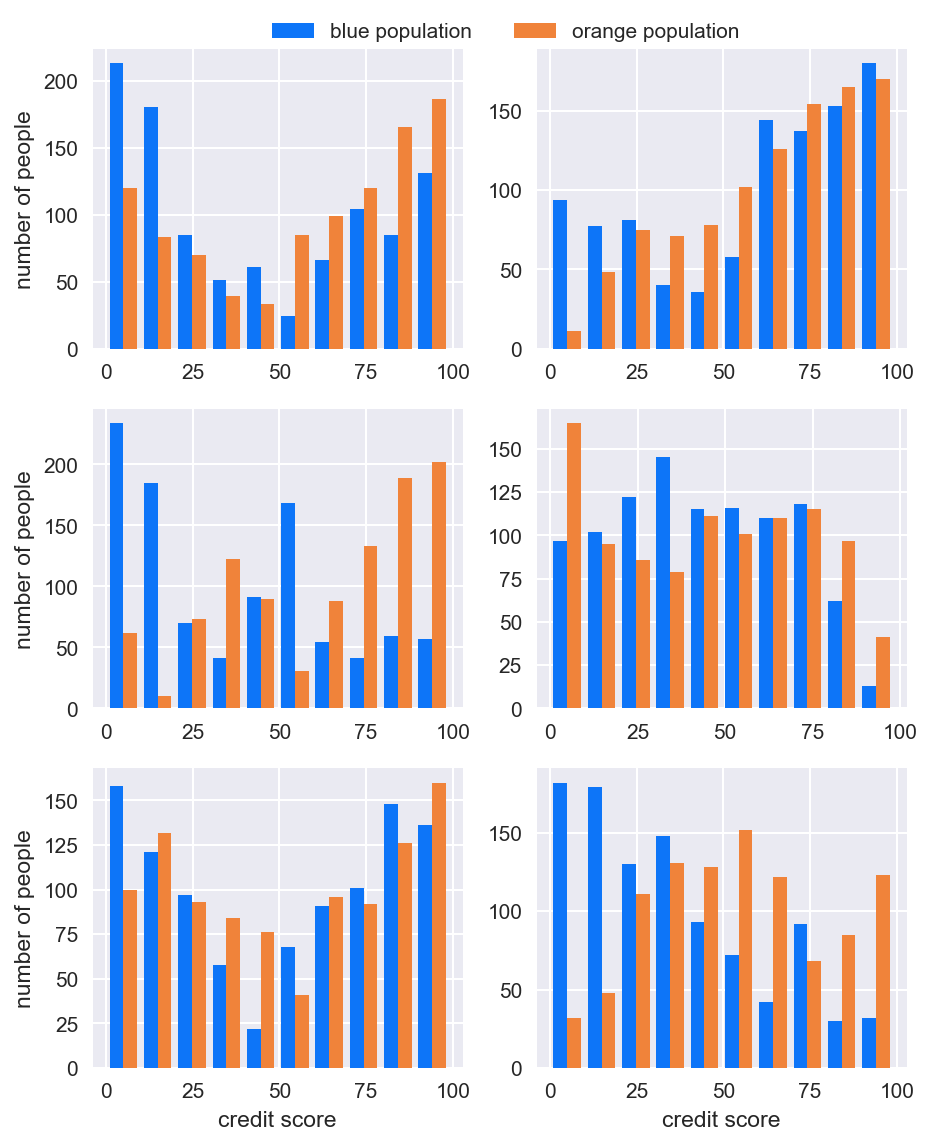

In [50]:
plt.figure(figsize=(7,9), dpi=150)       
sns.set_palette("Paired")


# fig = plt.figure()
# ax = plt.subplot(111)

# for i in xrange(5):
#     ax.plot(x, i * x, label='$y = %ix$' % i)

# ax.legend(bbox_to_anchor=(1.1, 1.05))


for i in range(6):
    a, b, c, d, mean_a, mean_b = create_blues_and_oranges()

    ax = plt.subplot(3, 2, i+1)

    plt.hist([a, b], color=['xkcd:deep sky blue', 'xkcd:dusty orange'])
    
    if(i==0):
        plt.ylabel("number of people")
        
        plt.legend(("blue population", "orange population"), bbox_to_anchor=(1.8, 1.15), ncol=2)
        
    
    if(i==2):
        plt.ylabel("number of people")
        
    if(i==4):
        plt.ylabel("number of people")
        plt.xlabel("credit score")
        
    if(i==5):
        plt.xlabel("credit score")
        

plt.savefig("plots/big_sim/blues_and_oranges.png")
plt.show()

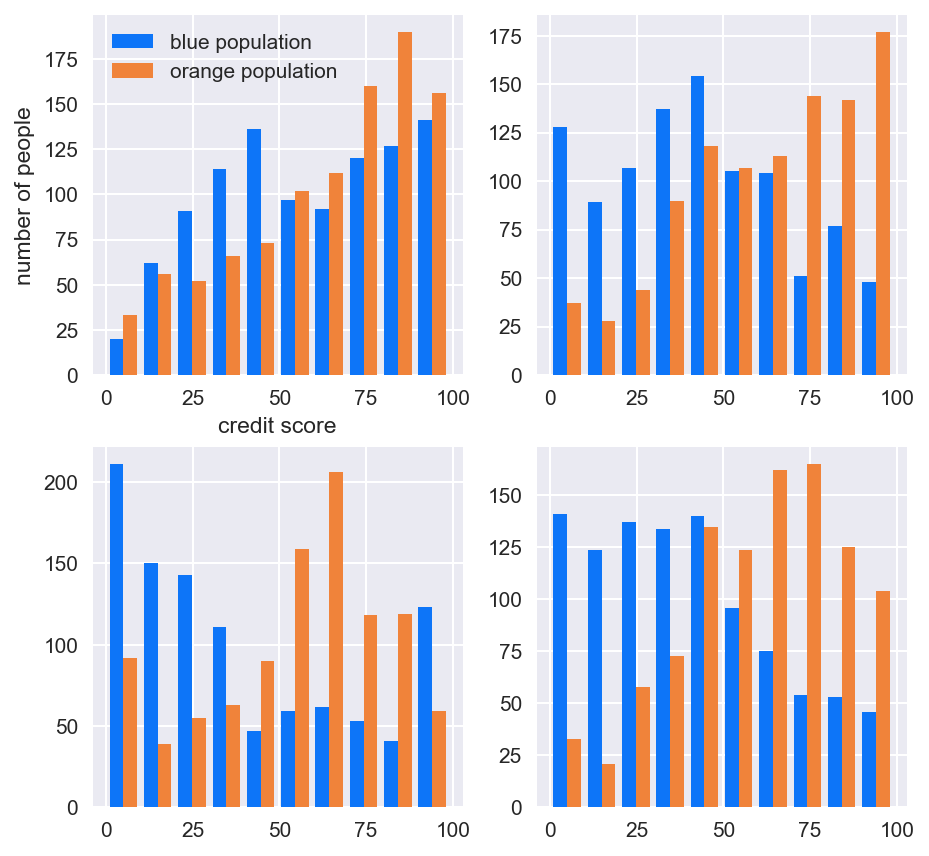

In [51]:
plt.figure(figsize=(7,7), dpi=150)       
sns.set_palette("Paired")
for i in range(4):
    a, b, c, d, mean_a, mean_b = create_blues_and_oranges()
    plt.subplot(2, 2, i+1)

    plt.hist([a, b], color=['xkcd:deep sky blue', 'xkcd:dusty orange'])
    
    if(i==0):
        plt.ylabel("number of people")
        plt.xlabel("credit score")
        plt.legend(("blue population", "orange population"))

plt.savefig("plots/big_sim/blues_and_oranges.png")
plt.show()

### 3. How many people default?

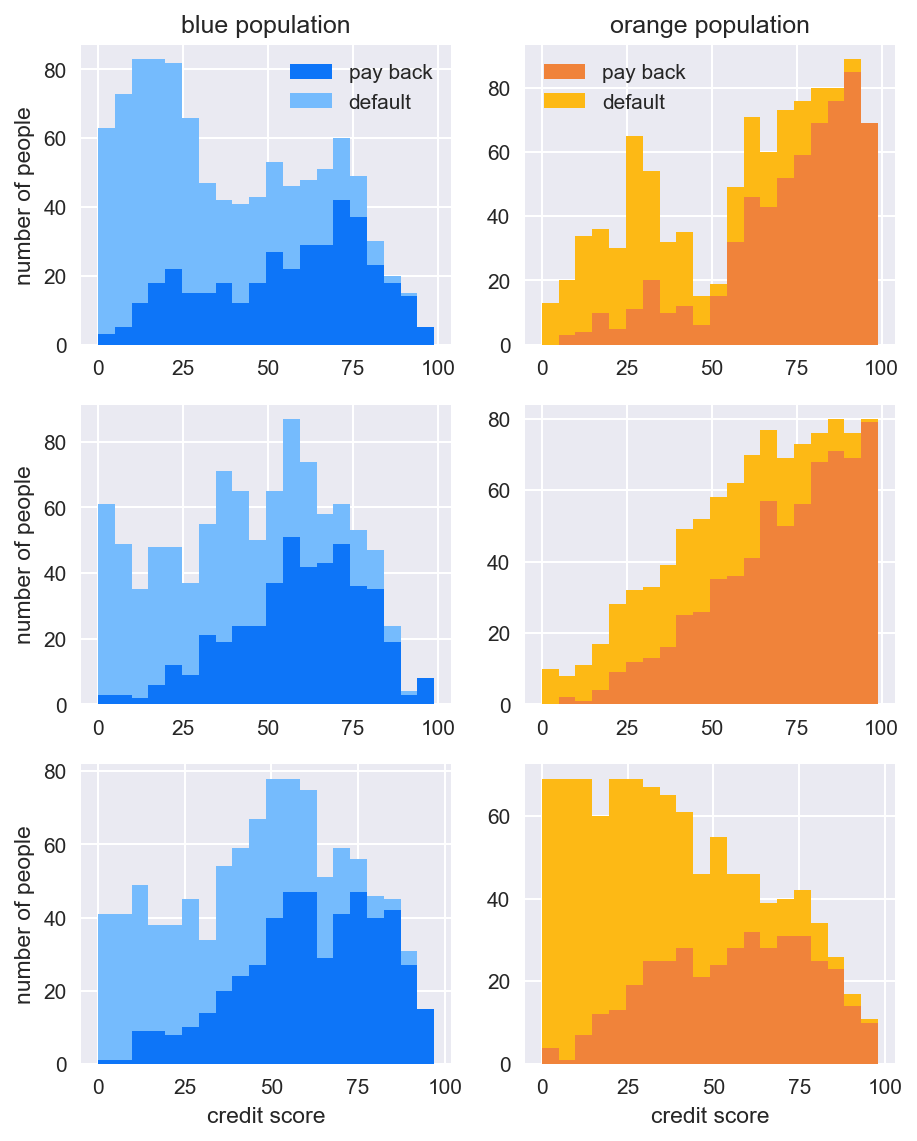

In [52]:
plt.figure(figsize=(7,9), dpi=150)       
sns.set_palette("Paired")
for i in range(6):
    a, b, c, d, _, _ = create_blues_and_oranges()
    plt.subplot(3, 2, i+1)
    
    if(i%2==0):
        plt.hist([a[np.logical_not(c)],a[c]], 
                 stacked=True, bins=20, color=("xkcd:deep sky blue", "xkcd:sky blue"))
    if(i%2==1):
        plt.hist([b[np.logical_not(d)],b[d]], 
                 stacked=True, bins=20, color=("xkcd:dusty orange", "xkcd:orangey yellow"))
    
    if(i==1):

        plt.legend(("pay back", "default"))
        plt.title("orange population")
        
    if(i==0):
        plt.legend(("pay back", "default"))
        plt.title("blue population")
        plt.ylabel("number of people")  
        
        
    if(i==2):
        plt.ylabel("number of people")
        
    if(i==4):
        plt.ylabel("number of people")
        plt.xlabel("credit score")
        
    if(i==5):
        plt.xlabel("credit score")
    

plt.savefig("plots/big_sim/defaults_no_defaults.png")
plt.show()